In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

### Gaussian filter 1D

$$
y_i = \sum_{j=-k}^{k} G(j) \cdot x_{i-j}
$$
With : 
$$
G(j) = \frac{1}{Z} \exp\left( -\frac{j^2}{2\sigma^2} \right), \quad Z = \sum_{l=-k}^{k} \exp\left( -\frac{l^2}{2\sigma^2} \right)
$$


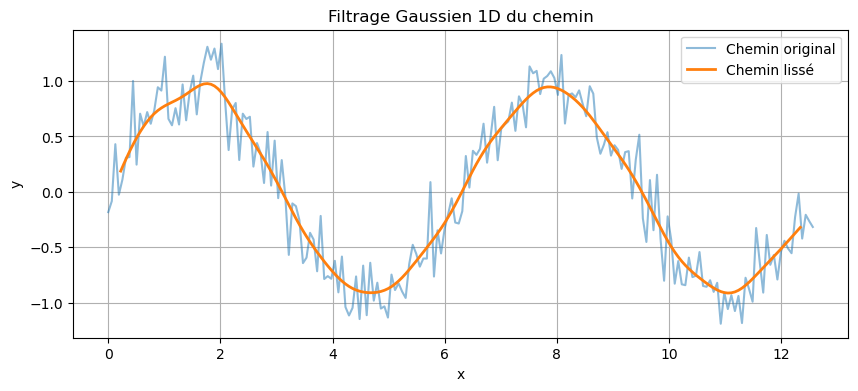

In [2]:

# Crée un chemin avec des oscillations
t = np.linspace(0, 4 * np.pi, 200)
x = t
y = np.sin(t) + 0.2 * np.random.randn(200)  # sinusoïde bruitée
path = np.stack([x, y], axis=1)

# Applique le filtre gaussien
smoothed_x = gaussian_filter1d(path[:, 0], sigma=5)
smoothed_y = gaussian_filter1d(path[:, 1], sigma=5)
smoothed_path = np.stack([smoothed_x, smoothed_y], axis=1)

# Affiche avant/après
plt.figure(figsize=(10, 4))
plt.plot(path[:, 0], path[:, 1], label="Chemin original", alpha=0.5)
plt.plot(smoothed_path[:, 0], smoothed_path[:, 1], label="Chemin lissé", linewidth=2)
plt.legend()
plt.title("Filtrage Gaussien 1D du chemin")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## SDF and velocity

In [3]:
from data_loader import load_sdf_from_csv,vel_read
import matplotlib.colors as mcolors
import numpy as np
from scipy.interpolate import RegularGridInterpolator

## 3D

In [19]:
def generate_helix(num_points=500, radius=1.0, pitch=0.1, turns=3,clockwise = True):
    t = np.linspace(0, 2 * np.pi * turns, num_points)
    if clockwise : 
        x = radius * np.sin(t) 
        z = radius * np.cos(t)
    else: 
        x = radius * np.cos(t) 
        z = radius * np.sin(t)
    y = pitch * t/(2*np.pi)
    curve = np.stack((x, y, z), axis=1)
    return curve

Distance between points : 1.0


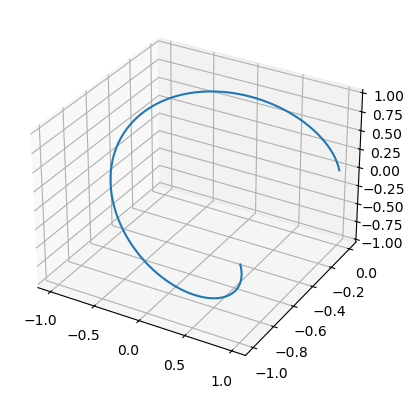

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

curve = generate_helix(2000, 1, -1,1,False)
print("Distance between points :", np.linalg.norm(curve[-1]-curve[0]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*curve.T)
plt.show()

Distance between points : 10.0


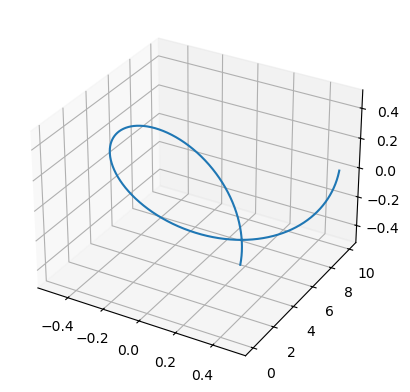

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

curve = generate_helix(2000, 1/2, 10,1,False)
print("Distance between points :", np.linalg.norm(curve[-1]-curve[0]))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*curve.T)
plt.show()

In [22]:
def draw_circle(center,radius):
    t = np.linspace(0,2*np.pi,200)
    print(center)
    x = center[0] * np.ones_like(t) + radius * np.cos(t)
    y = center[1] * np.ones_like(t) + radius * np.sin(t)
    z = np.ones_like(x) * center[-1]
    circle = np.stack((x,y,z),axis=1)
    return x,y,z


In [23]:
import numpy as np
import plotly.graph_objects as go


fig = go.Figure()

path = generate_helix(2000, 2 ,2.5, 1,True)
x = path[:,0]
y = path[:,1]
z = path[:,2]
# Création d’un plot 3D interactif
fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='lines',
    line=dict(color='blue', width=4)
))


# path = generate_helix(2000, 2, 1,1,False)
# x = path[:,0]
# y = path[:,1]
# z = path[:,2]
# # Création d’un plot 3D interactif
# fig.add_trace(go.Scatter3d(
#     x=x, y=y, z=z,
#     mode='lines',
#     line=dict(color='red', width=4)
# ))
# path = generate_helix(2000, 1/8, 1,1,False)
# x = path[:,0]
# y = path[:,1]
# z = path[:,2]
# # Création d’un plot 3D interactif
# fig.add_trace(go.Scatter3d(
#     x=x, y=y, z=z,
#     mode='lines',
#     line=dict(color='green', width=4)
# ))

# start = np.array([-1/2, 0, 0])
# direction = np.array([0, 1, 0])  # direction [1,0,0]
# fig.add_trace(go.Cone(
#     x=[start[0]],
#     y=[start[1]],
#     z=[start[2]],
#     u=[direction[0]],
#     v=[direction[1]],
#     w=[direction[2]],
#     sizemode="absolute",
#     sizeref=0.15,
#     anchor="tail",
#     colorscale=[[0, 'red'], [1, 'red']],
#     showscale=False,
#     name="Direction"
# ))

# a = 0.25
# cir = 2
# center = np.array([0, 0.6, -0.5])
# fig.add_trace(
#     go.Scatter3d(
#         x=[center[0]],
#         y=[center[1]],
#         z=[center[2]],
#         mode="markers",
#         marker=dict(size=3, color='black'),
#         name=f"Center",
#     )
# )

# x,y,z =draw_circle(center,a)
# fig.add_trace(go.Scatter3d(
#     x=x, y=y, z=z,
#     mode='lines',
#     line=dict(color='black', width=4),
#     name='vortex radius'
# ))

# Mise en forme
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
    ),
    title="Hélicoïdale 3D interactive"
)

# Enregistrer dans un fichier HTML
fig.write_html("helix_plot_bis.html")


### Frenet discussion

In [8]:
import numpy as np

# Courbe paramétrique simple : cercle
t = np.linspace(0, 2*np.pi, 100)
path = np.column_stack([np.cos(t), np.sin(t), np.zeros_like(t)])

# Calcul de T
dt = np.gradient(path, axis=0)  
T = dt / np.linalg.norm(dt, axis=1, keepdims=True)

dot_product_list =[] 
dot_recompute_list=[]
# Test d'orthogonalité
for i in range(1, len(T)):
    dT_discrete = T[i] - T[i-1]
    N = dT_discrete/np.linalg.norm(dT_discrete)
    dot_product = np.dot(T[i],N)
    dot_product_list.append(dot_product)
    B= np.cross(T[i], N)
    norm_B = np.linalg.norm(B)
    if norm_B > 1e-6:
        B /= norm_B
        N_new = np.cross(B, T[i])  # Re-orthonormalise
        dot_recompute_list.append(np.dot(T[i], N_new))

    # print(f"T[{i}] · dT = {dot_product:.6f}")

dot_product_array = np.array(dot_product_list)
print("Max : ",np.max(dot_product_array))
print("Min : ",np.min(dot_product_array))
print("Mean : ",np.mean(dot_product_array))

dot_product_recompute_array = np.array(dot_recompute_list)
print("Max : ",np.max(dot_product_recompute_array))
print("Min : ",np.min(dot_product_recompute_array))
print("Mean : ",np.mean(dot_product_recompute_array))

Max :  0.031727933498073235
Min :  0.015865963834807685
Mean :  0.03140748966648665
Max :  0.0
Min :  0.0
Mean :  0.0


## Meshgrid

In [24]:
import numpy as np

# Vecteurs d'entrée
x = np.array([1, 2, 3])
y = np.array([4, 5,6,7])

# Style matriciel ('ij')
Xi, Yi = np.meshgrid(x, y, indexing='ij')
print("Indexing 'ij':")
print("Xi shape:", Xi.shape)  
print("Yi shape:", Yi.shape)  
print("Xi:\n", Xi[0,1])
print("Yi:\n", Yi[0,1])

# Style cartésien ('xy')
Xx, Yx = np.meshgrid(x, y, indexing='xy')
print("\nIndexing 'xy':")
print("Xx shape:", Xx.shape) 
print("Yx shape:", Yx.shape) 
print("Xx:\n", Xx[0,1])
print("Yx:\n", Yx[0,1])

Indexing 'ij':
Xi shape: (3, 4)
Yi shape: (3, 4)
Xi:
 1
Yi:
 5

Indexing 'xy':
Xx shape: (4, 3)
Yx shape: (4, 3)
Xx:
 2
Yx:
 4


## RMF

In [9]:
import numpy as np

def normalize(v):
    return v / np.linalg.norm(v)

def double_reflection_rmf(points):
    points = np.array(points)
    n = len(points)

    # Tangents
    tangents = [normalize(points[i+1] - points[i]) for i in range(n - 1)]
    
    # Initial frame: choose arbitrary normal N0 orthogonal to T0
    T0 = tangents[0]
    arbitrary = np.array([0, 0, 1])
    if np.allclose(np.cross(T0, arbitrary), 0):
        arbitrary = np.array([1, 0, 0])
    N0 = normalize(np.cross(np.cross(T0, arbitrary), T0))
    B0 = np.cross(T0, N0)

    frames = [(T0, N0, B0)]
    N_prev = N0

    for i in range(1, n - 1):
        v1 = tangents[i - 1]
        v2 = tangents[i]

        # First reflection
        r = v2 + v1
        if np.linalg.norm(r) < 1e-10:  # 180° turn: reset
            N_curr = N_prev
        else:
            r = normalize(r)
            N_prime = N_prev - 2 * np.dot(N_prev, r) * r

            # Second reflection
            r = v2
            N_curr = N_prime - 2 * np.dot(N_prime, r) * r

        B_curr = np.cross(v2, N_curr)
        frames.append((v2, N_curr, B_curr))
        N_prev = N_curr

    return frames

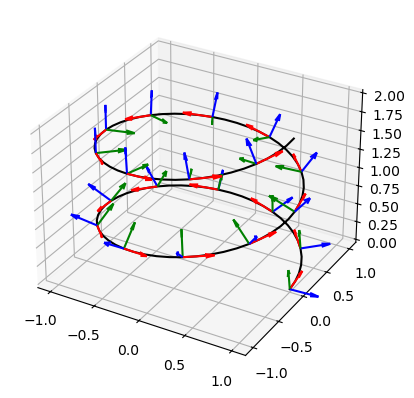

In [14]:
# Exemple : une hélice
t = np.linspace(0, 4 * np.pi, 100)
points = np.array([np.cos(t), np.sin(t), t / (2*np.pi)]).T

frames = double_reflection_rmf(points)

# Affichage avec matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(points[:, 0], points[:, 1], points[:, 2], 'k')

for i in range(0, len(frames), 5):  # un frame sur 5 pour la lisibilité
    p = points[i]
    T, N, B = frames[i]
    scale = 0.3
    ax.quiver(p[0], p[1], p[2], T[0], T[1], T[2], color='r', length=scale)
    ax.quiver(p[0], p[1], p[2], N[0], N[1], N[2], color='g', length=scale)
    ax.quiver(p[0], p[1], p[2], B[0], B[1], B[2], color='b', length=scale)

plt.show()

## Projection

Coordonnées relatives de l’agent : [ 6.04960169e-08 -1.32225092e-01]


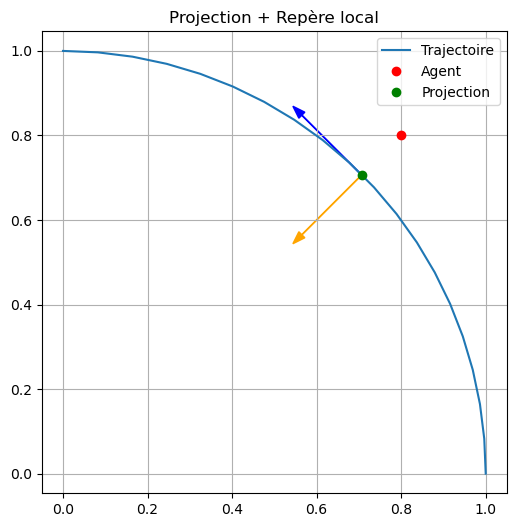

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def project_point_on_segment(p, a, b):
    """Projette le point p sur le segment [a, b]"""
    ab = b - a
    ap = p - a
    t = np.dot(ap, ab) / (np.dot(ab, ab) + 1e-8)
    t_clamped = np.clip(t, 0.0, 1.0)
    projection = a + t_clamped * ab
    return projection, t_clamped

def compute_closest_projection(p, path):
    """Trouve la projection de p sur les segments de la courbe"""
    min_dist = float('inf')
    closest_proj = None
    closest_index = 0
    closest_t = 0

    for i in range(len(path) - 1):
        a, b = path[i], path[i+1]
        proj, t = project_point_on_segment(p, a, b)
        dist = np.linalg.norm(p - proj)
        if dist < min_dist:
            min_dist = dist
            closest_proj = proj
            closest_index = i
            closest_t = t

    return closest_proj, closest_index, closest_t

def compute_local_frame(a, b):
    """Repère tangent-normal en 2D entre a et b"""
    tangent = b - a
    tangent /= np.linalg.norm(tangent)
    normal = np.array([-tangent[1], tangent[0]])  # rotation de 90°
    return tangent, normal

# ==== Exécution exemple ====

# Trajectoire = arc de cercle discretisé
theta = np.linspace(0, np.pi / 2, 20)
radius = 1.0
path = np.stack([radius * np.cos(theta), radius * np.sin(theta)], axis=1)

# Position de l'agent
agent_pos = np.array([0.8, 0.8])

# Projection de l’agent sur le chemin
proj, idx, t = compute_closest_projection(agent_pos, path)

# Interpolation locale
a, b = path[idx], path[idx+1]
frame_tangent, frame_normal = compute_local_frame(a, b)

# Coordonnées relatives dans le repère
relative_vec = agent_pos - proj
relative_coords = np.array([
    np.dot(relative_vec, frame_tangent),
    np.dot(relative_vec, frame_normal)
])

print(f"Coordonnées relatives de l’agent : {relative_coords}")

# ==== Visualisation ====
plt.figure(figsize=(6, 6))
plt.plot(path[:, 0], path[:, 1], label='Trajectoire')
plt.plot(agent_pos[0], agent_pos[1], 'ro', label='Agent')
plt.plot(proj[0], proj[1], 'go', label='Projection')

# Repère
scale = 0.2
plt.arrow(proj[0], proj[1], scale * frame_tangent[0], scale * frame_tangent[1], color='blue', head_width=0.02)
plt.arrow(proj[0], proj[1], scale * frame_normal[0], scale * frame_normal[1], color='orange', head_width=0.02)
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.title('Projection + Repère local')
plt.show()